In [1]:
import matplotlib.pyplot as plt
import numpy as np
import time
#from lwautils import lwa_arx 
import pandas as pd
from cr_data_inspection_functions import *
import struct
import math
from lwa_antpos import mapping
import os

##load arraymap
array_map=pd.read_csv('array-map-5-22-2023.csv')
xdict={}
ydict={}
zdict={}
for i,n in enumerate(array_map['antname']):
    xdict[n]=array_map['x'][i]
    ydict[n]=array_map['y'][i]
    zdict[n]=array_map['elevation'][i]
arraymapdictionaries=[xdict,ydict,zdict]

Read antpos from xlsx file in repo


In [10]:
#24th order
h= np.asarray([0.000049291111379545783611425685544205066,
               0.012255497574972781804625299173494568095,
               0.085289616177628382875930412865272955969,
               -0.063136263203890236050952466939634177834,
               -0.021489412960359111082198069198057055473,
               -0.067555957743183181474222465112688951194,
               -0.017706118779731286339007567676162580028,
               0.080882151494431037130894424080906901509,
               -0.014358148251631907416081546102759602945,
               0.093835202832724035060252276707615237683,
               -0.280577771800571862392814637132687494159,
               -0.129748808680352711864003367736586369574,
               0.501393724111570460166831253445707261562,
               -0.129748808680352711864003367736586369574,
               -0.280577771800571862392814637132687494159,
               0.093835202832724035060252276707615237683,
               -0.014358148251631907416081546102759602945,
               0.080882151494431037130894424080906901509,
               -0.017706118779731286339007567676162580028,
               -0.067555957743183181474222465112688951194,
               -0.021489412960359111082198069198057055473,
               -0.063136263203890236050952466939634177834,
               0.085289616177628382875930412865272955969,
               0.012255497574972781804625299173494568095,
               0.000049291111379545783611425685544205066])

## Check snapshot

In [36]:
fname='/data0/cosmic-ray-data/2023June30/test1688168925.1072624.dat' #file with a single snapshot
fname='/home/ubuntu/kp/data/2023July3-overnight-software-trigger/test1688443082.2519193.dat'
records=parsefile(fname)
mergedrecords=mergepolarizations(records,arraymapdictionaries)#,Filter=h)

antennas=np.asarray([int(record['antname'][4:]) for record in mergedrecords])
order_by_antname=sorted(zip(antennas,mergedrecords))
records_by_antname=[pair[1] for pair in order_by_antname]
sorted_antennas=[pair[0] for pair in order_by_antname]

#get rms before event -- this is actually the standard deviation
rmsA=np.asarray([record['rmsA'] for record in records_by_antname])
rmsB=np.asarray([record['rmsB'] for record in records_by_antname])

#get mean power before event
meansmoothedA=np.asarray([record['meansmoothedA'] for record in records_by_antname])
meansmoothedB=np.asarray([record['meansmoothedB'] for record in records_by_antname])

    
#get kurtosis before event
kurtosisA=np.asarray([record['kurtosisA'] for record in records_by_antname])
kurtosisB=np.asarray([record['kurtosisB'] for record in records_by_antname])


absmaxA=np.asarray([np.max(np.abs(record['polA_data'])) for record in records_by_antname])
absmaxB=np.asarray([np.max(np.abs(record['polB_data'])) for record in records_by_antname])                    

FileNotFoundError: [Errno 2] No such file or directory: '/home/ubuntu/kp/data/2023July3-overnight-software-trigger/test1688443082.2519193.dat'

(-10, 10)

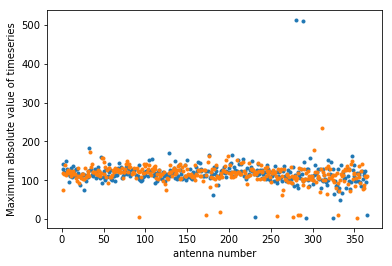

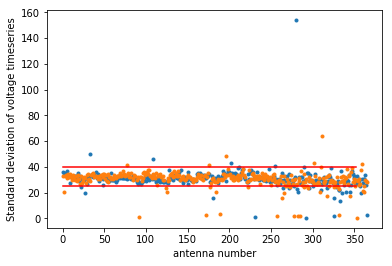

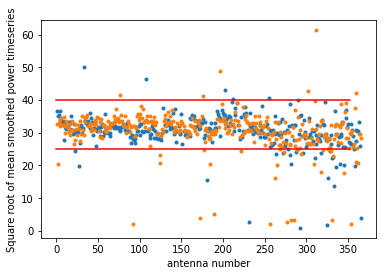

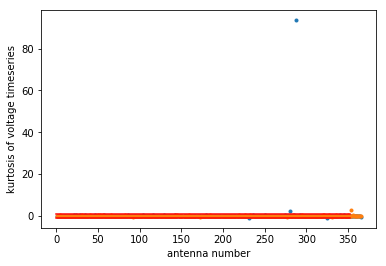

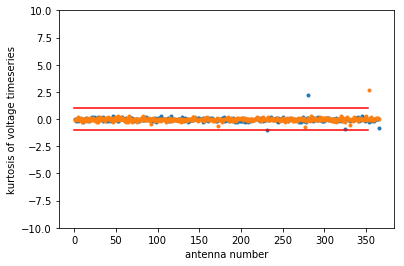

In [23]:
plt.figure()
plt.plot(sorted_antennas,absmaxA,'.',label='polA')
plt.plot(sorted_antennas,absmaxB,'.',label='polB')
plt.xlabel('antenna number')
plt.ylabel('Maximum absolute value of timeseries')

plt.figure()
plt.plot(sorted_antennas,rmsA,'.',label='polA')
plt.plot(sorted_antennas,rmsB,'.',label='polB')
plt.ylabel('Standard deviation of voltage timeseries')
plt.xlabel('antenna number')
plt.plot([0,352],[25,25],'r')
plt.plot([0,352],[40,40],'r')

plt.figure()
plt.plot(sorted_antennas,np.sqrt(meansmoothedA),'.',label='polA')
plt.plot(sorted_antennas,np.sqrt(meansmoothedB),'.',label='polB')
plt.ylabel('Square root of mean smoothed power timeseries')
plt.xlabel('antenna number')
plt.plot([0,352],[25,25],'r')
plt.plot([0,352],[40,40],'r')

plt.figure()
plt.plot(sorted_antennas,kurtosisA,'.',label='polA')
plt.plot(sorted_antennas,kurtosisB,'.',label='polB')
plt.ylabel('kurtosis of voltage timeseries')
plt.xlabel('antenna number')
plt.plot([0,352],[-1,-1],'r')
plt.plot([0,352],[1,1],'r')

plt.figure()
plt.plot(sorted_antennas,kurtosisA,'.',label='polA')
plt.plot(sorted_antennas,kurtosisB,'.',label='polB')
plt.ylabel('kurtosis of voltage timeseries')
plt.xlabel('antenna number')
plt.plot([0,352],[-1,-1],'r')
plt.plot([0,352],[1,1],'r')
plt.ylim(-10,10)
#plt.ylim(-1,100)

In [24]:
for r in mergedrecords:
    if r['kurtosisA']>90:
        print(r['antname'],r['kurtosisA'],r['kurtosisB'])


LWA-288 93.54475385293085 -0.055918670305691975


In [25]:
for r in mergedrecords:
    if r['antname']=='LWA-095':
        print(r['antname'],r['rmsA'],r['rmsB'])


LWA-095 27.95345853378433 28.969974244897077


## Define Veto Antennas

In [26]:


brdnames=['snap01','snap02','snap03','snap04','snap05','snap06','snap07','snap08','snap09','snap10','snap11']

#first, make arrays holding the veto and core antenna assignments, whether or not that antenna is online
veto_antennas_names={}
veto_antennas_names['snap08']=['LWA-322','LWA-326','LWA-333','LWA-347']
veto_antennas_names['snap05']=['LWA-328','LWA-325','LWA-334','LWA-316']
veto_antennas_names['snap10']=['LWA-297','LWA-350','LWA-356','LWA-342']
veto_antennas_names['snap11']=['LWA-264','LWA-261','LWA-315','LWA-300']
veto_antennas_names['snap04']=['LWA-331','LWA-348','LWA-364']
veto_antennas_names['snap09']=['LWA-349','LWA-329','LWA-290','LWA-357']
veto_antennas_names['snap07']=['LWA-287','LWA-279','LWA-355']
veto_antennas_names['snap06']=['LWA-319','LWA-299','LWA-289']
veto_antennas_names['snap03']=['LWA-275','LWA-286','LWA-302','LWA-363']
veto_antennas_names['snap01']=[] #TODO FILL THIS IN LATER
veto_antennas_names['snap02']=[] #TODO FILL THIS IN LATER


veto_roles=np.zeros((11,64),dtype=int)  #array to identify the antennas to be assigned as vetos
core_roles=np.ones((11,64),dtype=int)  #array to identify the antennas to be assigned as core antennas
for i in range(11):
    snap=brdnames[i]
    vetonames=veto_antennas_names[snap]
    for ant in vetonames:
        brd,inputnumberA=mapping.antpol_to_fpga(ant,'A')
        brd,inputnumberB=mapping.antpol_to_fpga(ant,'B')
        veto_roles[i,inputnumberA]=1 #set the veto role to 1 for inputs corresponding to veto antennas
        veto_roles[i,inputnumberB]=1
        core_roles[i,inputnumberA]=0 #set the core role to zero for veto antennas
        core_roles[i,inputnumberB]=0
        
        

##  now figure out which antennas are ok


In [27]:
#now figure out which antennas are ok
antenna_status_array=np.zeros((11,64),dtype=int)  #array whose elements are 1 if the antenna has an ok rms and 0 otherwise

minimum_acceptable_rms=25
maximum_acceptable_rms=40
minimum_acceptable_kurtosis=-10
maximum_acceptable_kurtosis=10
for r in mergedrecords:
    snap=r['board_id']
    brd_index=snap-1
    antenna_id_A=r['antenna_id_A']
    antenna_id_B=r['antenna_id_B']
    rmsA=r['rmsA']
    rmsB=r['rmsB']
    kurtosisA=r['kurtosisA']
    kurtosisB=r['kurtosisB']
    
    
    # if both polarizations pass both criteria, then use them, otherwise neither is ok
    if ((minimum_acceptable_kurtosis < kurtosisA < maximum_acceptable_kurtosis) and (minimum_acceptable_kurtosis < kurtosisB < maximum_acceptable_kurtosis) and (minimum_acceptable_rms < rmsA < maximum_acceptable_rms) and minimum_acceptable_rms < rmsB < maximum_acceptable_rms):
        antenna_status_array[brd_index,antenna_id_A]=1
        antenna_status_array[brd_index,antenna_id_B]=1

## Combine antenna status with core and veto roles

In [30]:
#calculate arrays of good veto antennas and good core antennas, and check which subarrays have enough
ok_vetos=np.multiply(antenna_status_array,veto_roles)
ok_core=np.multiply(antenna_status_array,core_roles)

for b in range(11):
    print('snap',b+1, np.sum(ok_vetos[b]),np.sum(ok_core[b]))
    
#np.save('/home/ubuntu/kp/ok_vetos-2023-6-30',ok_vetos)
#np.save('/home/ubuntu/kp/ok_core-2023-6-30',ok_core)

snap 1 0 34
snap 2 0 38
snap 3 6 52
snap 4 4 52
snap 5 4 52
snap 6 4 54
snap 7 6 54
snap 8 4 40
snap 9 6 52
snap 10 8 54
snap 11 6 50


In [35]:
ok_vetos=np.load('/home/ubuntu/kp/ok_vetos-2023-6-30.npy')
ok_core=np.load('/home/ubuntu/kp/ok_core-2023-6-30.npy')
for b in range(11):
    veto_roles_array=ok_vetos[b,:]
    core_roles_array=ok_core[b,:]
    print(np.sum(veto_roles_array),np.sum(core_roles_array))

0 34
0 38
6 52
4 52
4 52
4 54
6 54
4 40
6 52
8 54
6 50


In [ ]:
0 54
0 54
8 47
5 54
7 55
6 56
6 41
8 53
8 52
8 55
7 50
